In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/ealeongomez/Data.git
!git clone https://github.com/ealeongomez/Predictive-Modeling-Using-a-Clustering-Based-Approach.git
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'Data'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 46 (delta 10), reused 26 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (46/46), 17.70 MiB | 14.15 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Cloning into 'Predictive-Modeling-Using-a-Clustering-Based-Approach'...
remote: Enumerating objects: 210, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 210 (delta 5), reused 11 (delta 3), pack-reused 196 (from 1)
Receiving objects: 100% (210/210), 283.24 MiB | 31.71 MiB/s, done.
Resolving deltas: 100% (87/87), done.
Updating files: 100% (88/88), done.
Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 586, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 586 (delta 122), reused 82 (delta 82), pack-reused 434 (f

#**Libraries**

In [ ]:
# Basic packages
import pandas as pd
import shutil
import os, pickle, time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Machine learning packages
import cuml, cudf
from cuml.manifold.umap import UMAP as cuUMAP

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

from scipy.spatial.distance import cdist

In [ ]:
os.chdir('/content/Predictive-Modeling-Using-a-Clustering-Based-Approach')

In [ ]:
ls -l

total 3636
-rw-r--r-- 1 root root 1225140 Mar  1 17:51 Argone_IL.ipynb
-rw-r--r-- 1 root root 1212593 Mar  1 17:51 Beijing_Airport_China.ipynb
-rw-r--r-- 1 root root 1214371 Mar  1 17:51 Chengdu_Airport_China.ipynb
-rw-r--r-- 1 root root    1805 Mar  1 17:51 comparation.py
drwxr-xr-x 3 root root    4096 Mar  1 17:51 Experiments/
-rw-r--r-- 1 root root    2980 Mar  1 17:51 Final.py
drwxr-xr-x 2 root root    4096 Mar  1 17:51 Functions/
drwxr-xr-x 2 root root    4096 Mar  1 17:51 pkl/
-rw-r--r-- 1 root root    4868 Mar  1 17:51 plotter_individual.py
-rw-r--r-- 1 root root    4330 Mar  1 17:51 plotter.py
-rw-r--r-- 1 root root    1781 Mar  1 17:51 plot_TimeSeries.py
drwxr-xr-x 5 root root    4096 Mar  1 17:51 Proofs/
-rw-r--r-- 1 root root      56 Mar  1 17:51 README.md
-rw-r--r-- 1 root root     662 Mar  1 17:51 Resultados.eps
drwxr-xr-x 2 root root    4096 Mar  1 17:51 results/
drwxr-xr-x 3 root root    4096 Mar  1 17:51 stac/


In [ ]:
from Experiments.NeuralNetworks import ForecastingModels
from Experiments.organizeData import selectSamples

# **Variables**

In [ ]:
neurons = 9
layers = 1
epochs = 50
predictionHorizonMax = 7
n_splits = 5
data_timeSerie = 'Argone_IL'
batch_size = 512

In [ ]:
data = {"City": ["Chengdu_Airport_China", "Beijing_Airport_China", "Argone_IL"],
        "mse_RNN": [12, 12, 15], "mse_GRU": [11, 9, 7], "mse_LSTM": [11, 8, 8],
        "KernelMSE_RNN": [17, 9, 8], "KernelMSE_GRU": [20, 11, 12], "KernelMSE_LSTM": [20, 10, 13],
}

df_windows = pd.DataFrame(data)

display(df_windows)

,City,mse_RNN,mse_GRU,mse_LSTM,KernelMSE_RNN,KernelMSE_GRU,KernelMSE_LSTM
0,Chengdu_Airport_China,12,11,11,17,20,20
1,Beijing_Airport_China,12,9,8,9,11,10
2,Argone_IL,15,7,8,8,12,13


In [ ]:
windows = [7,8,9,10,11,12,13,15,17,20]

In [ ]:
# Logspace threshold
# Maximum radius
print(cdist(np.array([-1,-1]).reshape(1,-1),np.array([1,1]).reshape(1,-1))/4)

th = np.logspace(np.log10(0.01), np.log10(0.7), num=10).round(2)
print(th.round(2))

thresholds = [0.02, 0.03, 0.04, 0.11, 0.7]

[[0.70710678]]
[0.01 0.02 0.03 0.04 0.07 0.11 0.17 0.27 0.44 0.7 ]


# **Load data**

In [ ]:
dataSet = {}

## Argonne IL

In [ ]:
df_1 = pd.read_csv("/content/Data/WindSpeed/Argone_IL.txt", sep="\t",  names=['yyyymmdd','hhmn','mph','code'])
df_1 = df_1[df_1["yyyymmdd"] >= 19980101]

df_1.head()

,yyyymmdd,hhmn,mph,code
438312,19980101,100,10.51,0
438313,19980101,200,11.63,0
438314,19980101,300,11.86,0
438315,19980101,400,14.09,0
438316,19980101,500,14.99,0


32.44 0.0


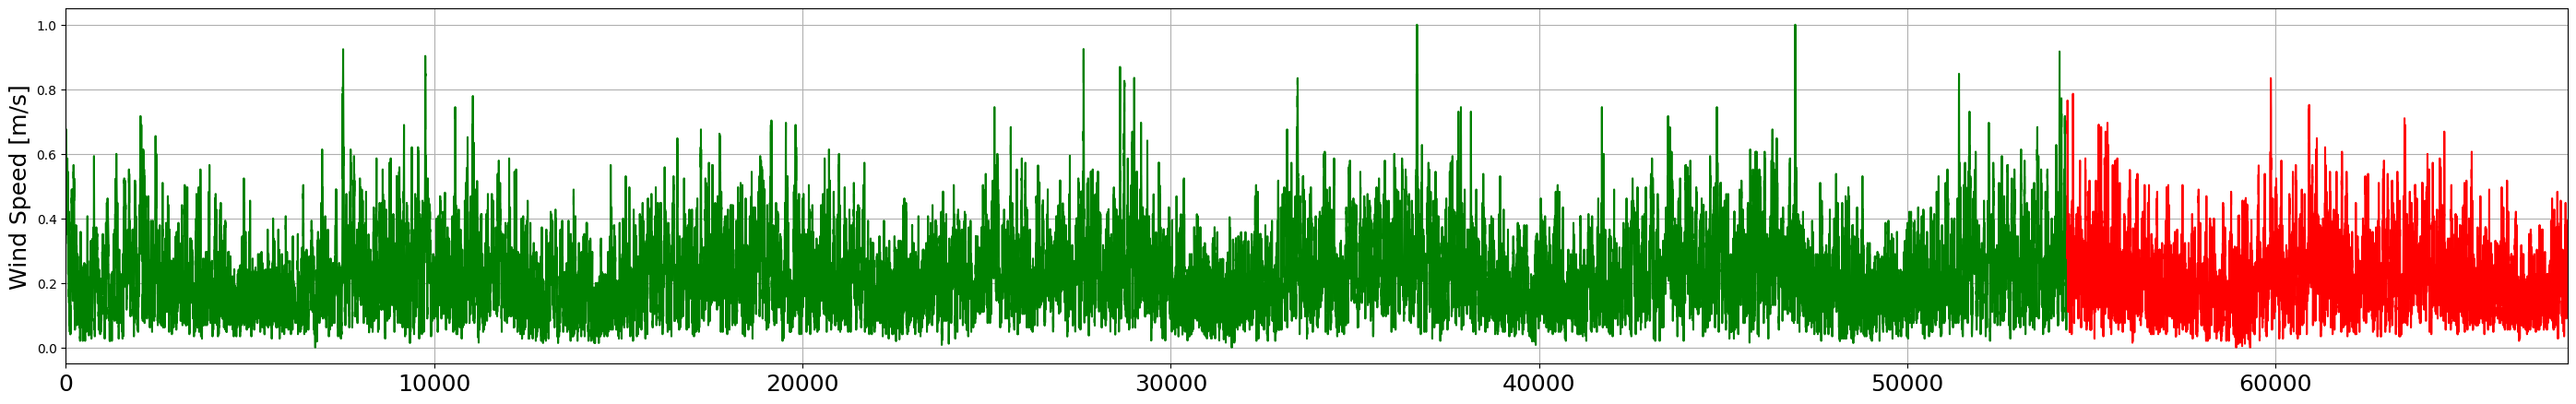

In [ ]:
df_1["sped"] = pd.to_numeric(df_1["mph"], downcast="float")
timeSerie_1 = df_1.iloc[:,2].values

valueMax_1 = max(timeSerie_1)
print(max(timeSerie_1), min(timeSerie_1))
val = valueMax_1

timeSerie_1 = (timeSerie_1-min(timeSerie_1))/(valueMax_1-min(timeSerie_1))
samples = round(len(timeSerie_1)*0.80)

timeSerie_training_1 = timeSerie_1[0:samples]
timeSerie_test_1     = timeSerie_1[samples:]
time_1 = np.arange(0, len(timeSerie_1),1)

# Ploter el conjunto de datos
plt.figure(figsize=(35,5))
plt.plot(time_1[0:samples], timeSerie_1[0:samples], 'g', label= 'Training samples')
plt.plot(time_1[samples:], timeSerie_1[samples:], 'r', label= 'Test')
plt.xticks(fontsize=18)
plt.ylabel('Wind Speed [m/s]', fontsize=18)
plt.xlim(0, timeSerie_1.shape[0])
plt.grid(True)
plt.show()

In [ ]:
for window in windows:
  selectSamples_ = selectSamples(timeSerie_training_1, predictionHorizonMax, window)
  X_, y_ = selectSamples_.SerieMatriz()

  selectSamples_test = selectSamples(timeSerie_test_1, predictionHorizonMax, window)
  X_test, y_test = selectSamples_test.SerieMatriz()

  dict_aux = {"{}".format(window): {'train': [X_, y_], 'test':[X_test, y_test]}}
  dataSet.setdefault("Argone_IL", {}).update(dict_aux)

  print(X_.shape, y_.shape, X_test.shape, y_test.shape)

(54323, 7) (54323, 7) (13571, 7) (13571, 7)
(54322, 8) (54322, 7) (13570, 8) (13570, 7)
(54321, 9) (54321, 7) (13569, 9) (13569, 7)
(54320, 10) (54320, 7) (13568, 10) (13568, 7)
(54319, 11) (54319, 7) (13567, 11) (13567, 7)
(54318, 12) (54318, 7) (13566, 12) (13566, 7)
(54317, 13) (54317, 7) (13565, 13) (13565, 7)
(54315, 15) (54315, 7) (13563, 15) (13563, 7)
(54313, 17) (54313, 7) (13561, 17) (13561, 7)
(54310, 20) (54310, 7) (13558, 20) (13558, 7)


## Beijing Ariport China

In [ ]:
df_2 = pd.read_csv('/content/Data/WindSpeed/Beijing_Airport_China2.txt', delimiter=",")

df_2.head()

,valid,sped,station
0,2011-08-01 00:00:00,2.24,ZBAA
1,2011-08-01 01:00:00,2.24,ZBAA
2,2011-08-01 02:00:00,4.47,ZBAA
3,2011-08-01 03:00:00,4.47,ZBAA
4,2011-08-01 04:00:00,4.47,ZBAA


40.235 0.0


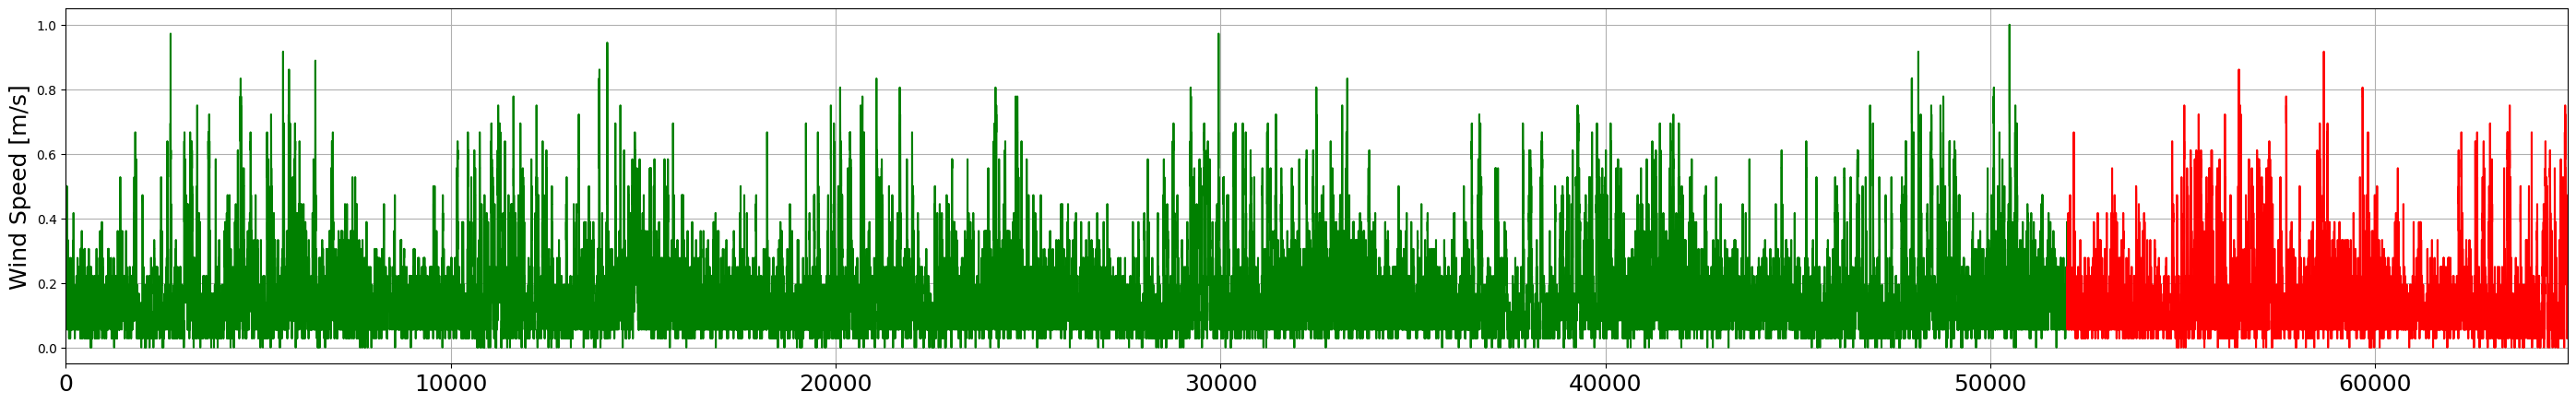

In [ ]:
df_2["sped"] = pd.to_numeric(df_2["sped"], downcast="float")
timeSerie_2 = df_2.iloc[:,1].values

valueMax_2 = max(timeSerie_2)
print(max(timeSerie_2), min(timeSerie_2))

timeSerie_2 = (timeSerie_2-min(timeSerie_2))/(valueMax_2-min(timeSerie_2))

samples = round(len(timeSerie_2)*0.80)

timeSerie_training_2 = timeSerie_2[0:samples]
timeSerie_test_2     = timeSerie_2[samples:]
time_2 = np.arange(0, len(timeSerie_2),1)

# Ploter el conjunto de datos
plt.figure(figsize=(35,5))
plt.plot(time_2[0:samples], timeSerie_2[0:samples], 'g', label= 'Training samples')
plt.plot(time_2[samples:], timeSerie_2[samples:], 'r', label= 'Test')
plt.xticks(fontsize=18)
plt.ylabel('Wind Speed [m/s]', fontsize=18)
plt.xlim(0, timeSerie_2.shape[0])
plt.grid(True)
plt.show()

In [ ]:
for window in windows:
  selectSamples_ = selectSamples(timeSerie_training_2, predictionHorizonMax, window)
  X_, y_ = selectSamples_.SerieMatriz()

  selectSamples_test = selectSamples(timeSerie_test_2, predictionHorizonMax, window)
  X_test, y_test = selectSamples_test.SerieMatriz()

  dict_aux = {"{}".format(window): {'train': [X_, y_], 'test':[X_test, y_test]}}
  dataSet.setdefault("Beijing_Airport_China", {}).update(dict_aux)

  print(X_.shape, y_.shape, X_test.shape, y_test.shape)

(51981, 7) (51981, 7) (12985, 7) (12985, 7)
(51980, 8) (51980, 7) (12984, 8) (12984, 7)
(51979, 9) (51979, 7) (12983, 9) (12983, 7)
(51978, 10) (51978, 7) (12982, 10) (12982, 7)
(51977, 11) (51977, 7) (12981, 11) (12981, 7)
(51976, 12) (51976, 7) (12980, 12) (12980, 7)
(51975, 13) (51975, 7) (12979, 13) (12979, 7)
(51973, 15) (51973, 7) (12977, 15) (12977, 7)
(51971, 17) (51971, 7) (12975, 17) (12975, 7)
(51968, 20) (51968, 7) (12972, 20) (12972, 7)


## Chengdu Airport China

In [ ]:
df_3 = pd.read_csv("/content/Data/WindSpeed/Chengdu_Airport_China.txt", sep=",")

df_3.head()

,station,valid,sped
0,ZUUU,2011-01-01 00:00,8.94
1,ZUUU,2011-01-01 01:00,4.47
2,ZUUU,2011-01-01 02:00,6.71
3,ZUUU,2011-01-01 03:00,6.71
4,ZUUU,2011-01-01 04:00,6.71


33.53 0.0


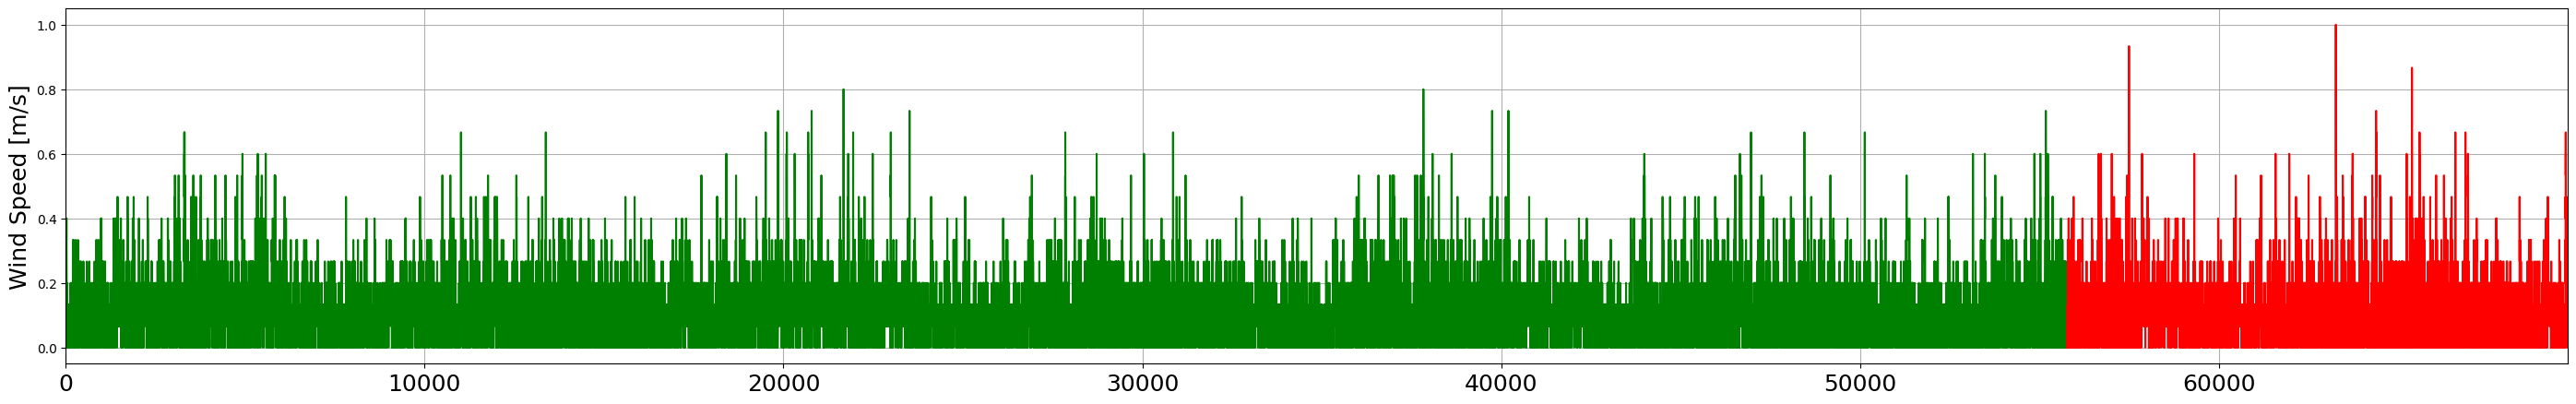

In [ ]:
df_3["sped"] = pd.to_numeric(df_3["sped "], downcast="float")
timeSerie_3 = df_3.iloc[:,2].values

valueMax_3 = max(timeSerie_3)
print(max(timeSerie_3), min(timeSerie_3))

timeSerie_3 = (timeSerie_3-min(timeSerie_3))/(valueMax_3-min(timeSerie_3))
samples = round(len(timeSerie_3)*0.80)

timeSerie_training_3 = timeSerie_3[0:samples]
timeSerie_test_3     = timeSerie_3[samples:]
time_3 = np.arange(0, len(timeSerie_3),1)

# Ploter el conjunto de datos
plt.figure(figsize=(35,5))
plt.plot(time_3[0:samples], timeSerie_3[0:samples], 'g', label= 'Training samples')
plt.plot(time_3[samples:], timeSerie_3[samples:], 'r', label= 'Test')
plt.xticks(fontsize=18)
plt.ylabel('Wind Speed [m/s]', fontsize=18)
plt.xlim(0, timeSerie_3.shape[0])
plt.grid(True)
plt.show()

In [ ]:
for window in windows:
  selectSamples_ = selectSamples(timeSerie_training_3, predictionHorizonMax, window)
  X_, y_ = selectSamples_.SerieMatriz()

  selectSamples_test = selectSamples(timeSerie_test_3, predictionHorizonMax, window)
  X_test, y_test = selectSamples_test.SerieMatriz()

  dict_aux = {"{}".format(window): {'train': [X_, y_], 'test':[X_test, y_test]}}
  dataSet.setdefault("Chengdu_Airport_China", {}).update(dict_aux)

  print(X_.shape, y_.shape, X_test.shape, y_test.shape)

(55757, 7) (55757, 7) (13930, 7) (13930, 7)
(55756, 8) (55756, 7) (13929, 8) (13929, 7)
(55755, 9) (55755, 7) (13928, 9) (13928, 7)
(55754, 10) (55754, 7) (13927, 10) (13927, 7)
(55753, 11) (55753, 7) (13926, 11) (13926, 7)
(55752, 12) (55752, 7) (13925, 12) (13925, 7)
(55751, 13) (55751, 7) (13924, 13) (13924, 7)
(55749, 15) (55749, 7) (13922, 15) (13922, 7)
(55747, 17) (55747, 7) (13920, 17) (13920, 7)
(55744, 20) (55744, 7) (13917, 20) (13917, 7)


# **UMAP**

In [ ]:
cuumap = cuUMAP(n_components=2, # The dimension of the space to embed into.
                n_neighbors=30, # The size of local neighborhood (from 1 to 100)
                )

In [ ]:
scaler_all = MinMaxScaler(feature_range=(-1, 1))

#**Training Neural Networks**

In [ ]:
df_long = df_windows.melt(id_vars=['City'], var_name='Loss_cost', value_name='Window')

In [ ]:
names_ = list(dataSet.keys())
names_

['Argone_IL', 'Beijing_Airport_China', 'Chengdu_Airport_China']

In [ ]:
temp_file_path = "/content/drive/MyDrive/temp_results_forecasting.csv"
drive_file_path = "/content/drive/MyDrive/results_forecasting.csv"

file_exists = os.path.exists(drive_file_path)


results_list = []
for _, row in df_long.iterrows():
    dataName = row['City']
    parts = row['Loss_cost'].split('_')
    cost_function = parts[-2]
    network_type = parts[-1]
    window = row['Window']

    print(f"\n City: {dataName}, Loss: {cost_function}, Neural Network: {network_type}, Window: {window}")
    X, y, label_data = np.empty(shape=[0, window]), np.empty(shape=[0, predictionHorizonMax]), np.empty(shape=[0, 1])

    # Training samples
    for i, name in enumerate(names_):
        X_plot = dataSet[name][str(window)]["train"][0]
        Y_plot = dataSet[name][str(window)]["train"][1]
        norm_X_plot = np.linalg.norm(X_plot, axis=1, keepdims=True)
        if i == 0:
            Xc = X_plot
            Yc = Y_plot
            normc_ = norm_X_plot
            label_dat = (i + 1) * np.ones((X_plot.shape[0], 1))
        else:
            Xc = np.r_[Xc, X_plot]
            Yc = np.r_[Yc, Y_plot]
            normc_ = np.r_[normc_, norm_X_plot]
            label_dat = np.r_[label_dat, (i + 1) * np.ones((X_plot.shape[0], 1))]

    # UMAP (over all samples)
    Z = cuumap.fit_transform(Xc)
    Z = scaler_all.fit_transform(Z)

    # UMAP
    city_index_map = {"Argone_IL": 1, "Beijing_Airport_China": 2, "Chengdu_Airport_China": 3}
    Z_dataBase = Z[label_dat.ravel() == city_index_map.get(row.City, -1)]

    clusterNumbers = 6
    model_KMeans = KMeans(n_clusters=int(clusterNumbers))
    y_KMeans = model_KMeans.fit(Z)
    label = model_KMeans.predict(Z_dataBase)
    centroids = model_KMeans.cluster_centers_
    centroids_x_umap = centroids[:, 0]
    centroids_y_umap = centroids[:, 1]

    # Test samples
    X_test = dataSet[dataName][str(window)]['test'][0]
    y_test = dataSet[dataName][str(window)]['test'][1]

    # Clustering
    index = None
    count = 0
    centroidValues_y = np.zeros((len(centroids_x_umap), len(thresholds)))
    for threshold in thresholds:

        print(' ----- ', threshold, ' ----- ')

        for j in np.arange(0, (len(centroids_x_umap))):
            # Distancia euclídea
            num = np.linalg.norm(centroids[j] - Z, axis=1) ** 2
            result = np.where(num < threshold)

            centroidValues_y[j, count] = len(result[0])

            if index is None:
                index = result[0]
            else:
                index = np.hstack((index, result[0]))

        count += 1

        # Select samples
        index = list(np.unique(index))
        X_ = Xc[index, :]
        y_ = Yc[index]
        X_ = np.reshape(X_, (X_.shape[0], X_.shape[1], 1))

        print(X_.shape, y_.shape, X_test.shape, y_test.shape)

        # Load model
        model = ForecastingModels(X_, y_, X_test, y_test, neurons=neurons, batch_size=2048,
                                  epochs=30, loss_function=cost_function, num_layers=1, n_splits=5, use_cv=False)

        # Seleccionar la arquitectura de red sin guardar el modelo
        if network_type == "RNN":
            metrics, dict_metrics, _, _, _ = model.RNNSimple_Model()
        elif network_type == "GRU":
            metrics, dict_metrics, _, _, _ = model.GRU_Model()
        elif network_type == "LSTM":
            metrics, dict_metrics, _, _, _ = model.LSTM_Model()
        else:
            raise ValueError(f"Tipo de red no reconocido: {network_type}")

        # Guardar solo métricas en lista
        result_dict = {
            "City": row.City,
            "Window": window,
            "Threshold": threshold,
            "Cost_Function": cost_function,
            "Network_Type": network_type,
            **dict_metrics  # Se desglosan las métricas en columnas
            }

        # Guardar resultado inmediatamente en archivo temporal
        result_df = pd.DataFrame([result_dict])
        result_df.to_csv(temp_file_path, mode='a', header=not file_exists, index=False)
        file_exists = True  # Para evitar escribir el header más de una vez

        print(f"Guardado temporalmente en '{temp_file_path}'")



 City: Chengdu_Airport_China, Loss: mse, Neural Network: RNN, Window: 12
 -----  0.02  ----- 
(77012, 12, 1) (77012, 7) (13925, 12) (13925, 7)
436/436 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step
Guardado temporalmente en '/content/drive/MyDrive/temp_results_forecasting.csv'
 -----  0.03  ----- 
(109740, 12, 1) (109740, 7) (13925, 12) (13925, 7)
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Guardado temporalmente en '/content/drive/MyDrive/temp_results_forecasting.csv'
 -----  0.04  ----- 
(130841, 12, 1) (130841, 7) (13925, 12) (13925, 7)
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Guardado temporalmente en '/content/drive/MyDrive/temp_results_forecasting.csv'
 -----  0.11  ----- 
(161688, 12, 1) (161688, 7) (13925, 12) (13925, 7)
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Guardado temporalmente en '/content/drive/MyDrive/temp_results_forecasting.csv'
 -----  0.7  ----- 
(161910, 12, 1) (161910, 7) (13925, 12) (13925, 7)
436/436 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
Guardado temporalmente en '/content/drive/